In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.13.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.2 MB/s eta 0:00:00
  Attempting uninstall: 

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# Display the version
print(tf.__version__)

# import and mount Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

2.13.0
Mounted at /content/gdrive


In [2]:
# get path to folder file is in
file_path = '/content/gdrive/MyDrive/Orthogonal'
print(file_path)

/content/gdrive/MyDrive/Orthogonal


In [3]:
# Download the data from tf, unless it's already here.
if not os.path.exists(file_path+'/data/clean'):
  os.mkdir(file_path+'/data/clean')
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
  np.save(file_path+'/data/clean/X_train.npy',X_train)
  np.save(file_path+'/data/clean/y_train.npy',y_train)
  np.save(file_path+'/data/clean/X_test.npy',X_test)
  np.save(file_path+'/data/clean/y_test.npy',y_test)
else:
  X_train = np.load(file_path+'/data/clean/X_train.npy')
  y_train = np.load(file_path+'/data/clean/y_train.npy')
  X_test = np.load(file_path+'/data/clean/X_test.npy')
  y_test = np.load(file_path+'/data/clean/y_test.npy')

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [4]:
# Convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Decrease pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

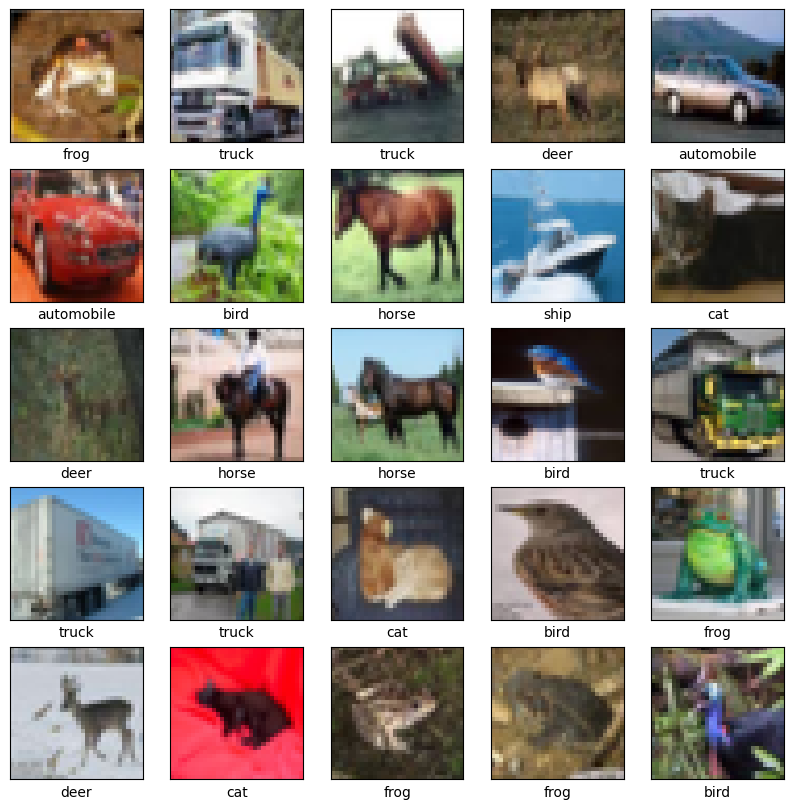

In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [5]:
# Load in Clean Model
model = tf.keras.models.load_model(file_path+'/models/clean.keras')

In [6]:
# Create FGSM Perturbed Data
def create_fgsm_perturbations(data_inputs, data_labels, epsilon = 0.1):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output_tensor = model(input_tensor)
    loss = loss_fn(label_tensor, output_tensor)

  gradient = tape.gradient(loss, input_tensor)
  perturbed_input_tensor = input_tensor + epsilon * tf.sign(gradient)
  return tf.cast(perturbed_input_tensor, dtype=input_tensor.dtype)

# Create FGSM perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/FGSM_perturbed'):
  os.mkdir(file_path+'/data/FGSM_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_FGSM_train = np.concatenate(perturbed_data, axis=0)
  X_FGSM_test = create_fgsm_perturbations(X_test, y_test)

  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy',X_FGSM_train)
  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy',X_FGSM_test)
else:
  X_FGSM_train = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy')
  X_FGSM_test = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy')

print("X_FGSM_train shape", X_FGSM_train.shape)
print("y_train shape", y_train.shape)
print("X_FGSM_test shape", X_FGSM_test.shape)
print("y_test shape", y_test.shape)

X_FGSM_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_FGSM_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [7]:
# Clip perturbed training and test data to viable values
X_FGSM_train = np.clip(X_FGSM_train, a_min = 0.0, a_max = 1.0)
X_FGSM_test = np.clip(X_FGSM_test, a_min = 0.0, a_max = 1.0)

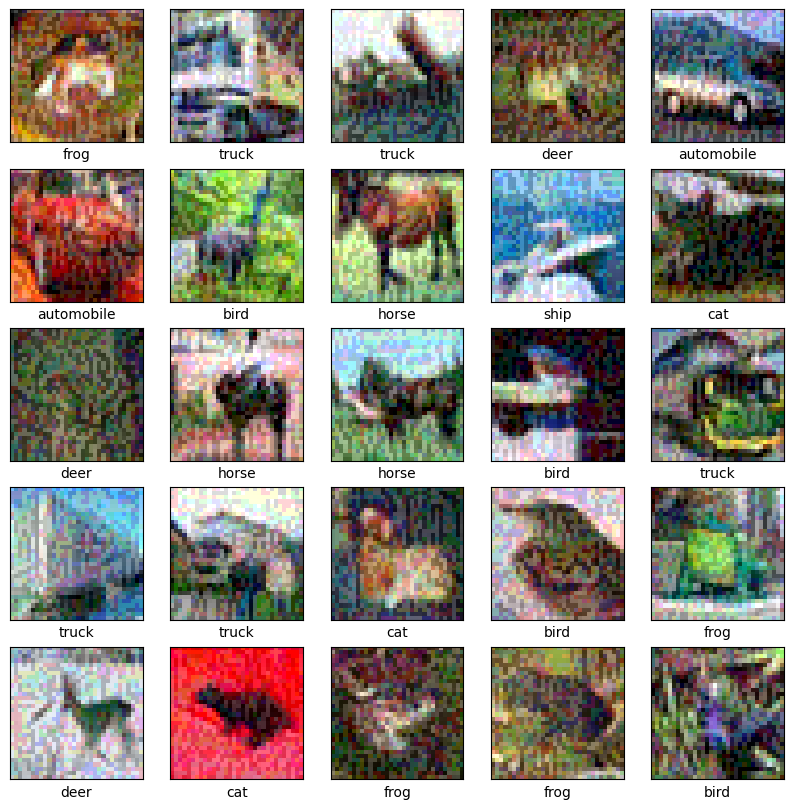

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_FGSM_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [9]:
model.evaluate(X_FGSM_train, y_train)
model.evaluate(X_FGSM_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 6.7091 - accuracy: 0.0394


[6.709075927734375, 0.039400000125169754]

In [10]:
# Create PGD Perturbed Data
def create_pgd_perturbations(data_inputs, data_labels, epsilon = 0.01, n_iter = 10):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  perturbed_tensor = input_tensor
  for i in range(n_iter):
      with tf.GradientTape() as tape:
          tape.watch(perturbed_tensor)
          output_tensor = model(perturbed_tensor)
          loss = loss_fn(label_tensor, output_tensor)

      gradient = tape.gradient(loss, perturbed_tensor)

      perturbed_tensor = perturbed_tensor + gradient
      # Project perturbed_tensor onto the L-infinity ball around input_tensor
      perturbed_tensor = epsilon * tf.sign(
          perturbed_tensor - input_tensor) + input_tensor

  perturbed_tensor = tf.cast(perturbed_tensor, dtype=input_tensor.dtype)
  return perturbed_tensor

# Create PGD perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/PGD_perturbed'):
  os.mkdir(file_path+'/data/PGD_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_PGD_train = np.concatenate(perturbed_data, axis=0)
  X_PGD_test = create_pgd_perturbations(X_test, y_test)

  np.save(file_path+'/data/PGD_perturbed/X_PGD_train.npy',X_PGD_train)
  np.save(file_path+'/data/PGD_perturbed/X_PGD_test.npy',X_PGD_test)
else:
  X_PGD_train = np.load(file_path+'/data/PGD_perturbed/X_PGD_train.npy')
  X_PGD_test = np.load(file_path+'/data/PGD_perturbed/X_PGD_test.npy')

print("X_PGD_train shape", X_PGD_train.shape)
print("y_train shape", y_train.shape)
print("X_PGD_test shape", X_PGD_test.shape)
print("y_test shape", y_test.shape)

X_PGD_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_PGD_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [11]:
# Clip perturbed training and test data to viable values
X_PGD_train = np.clip(X_PGD_train, a_min = 0.0, a_max = 1.0)
X_PGD_test = np.clip(X_PGD_test, a_min = 0.0, a_max = 1.0)

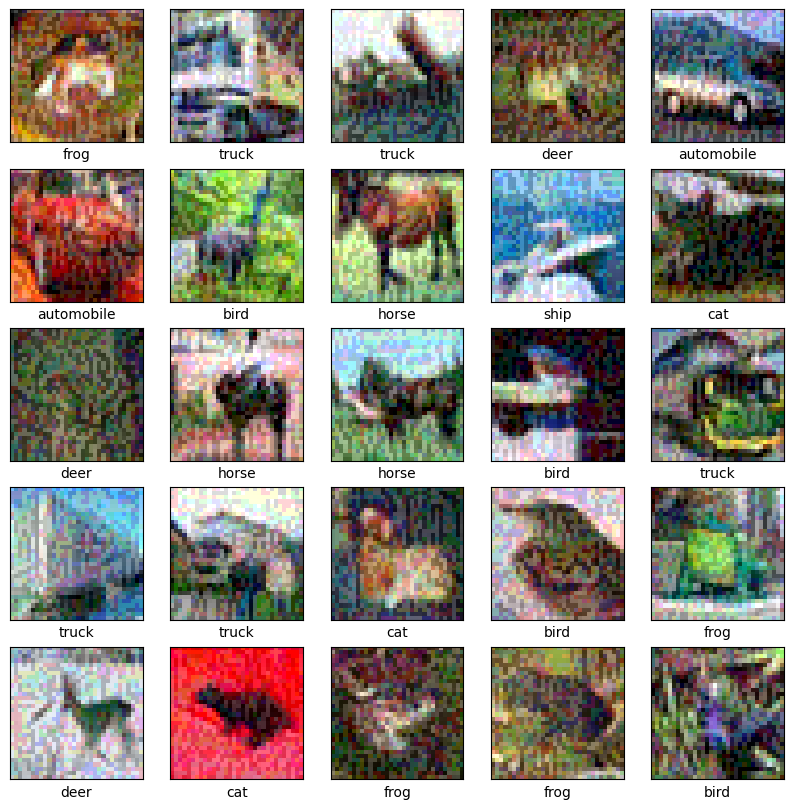

In [12]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_PGD_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [13]:
model.evaluate(X_PGD_train, y_train)
model.evaluate(X_PGD_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 2.9631 - accuracy: 0.3434


[2.9630656242370605, 0.3434000015258789]

In [16]:
print(X_train.shape[1:])

(32, 32, 3)


In [40]:
# Implement the chosen values in a final model, from https://github.com/rajeevsahay/ae-defenses/blob/master/Semi-white_Box_Attack_(FGSM)/pp_auto_encoder_fgsm.py
def train_autoencoder(data_total_train, data_total_test, labels_total_train = np.concatenate([X_train, X_train], axis=0), labels_total_test = np.concatenate([X_test, X_test], axis=0), file_name=(file_path + '/models/denoising_autoencoder.keras'), num_epochs = 25, batch_size=256, lr=0.0003):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=data_total_train.shape[1:]))
    model.add(tf.keras.layers.Dense(2500, activation="relu", use_bias=True, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(2000, activation="relu", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(1500, activation="relu", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(2000, activation="relu", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(2500, activation="relu", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(3072, activation="sigmoid", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Reshape(data_total_train.shape[1:]))

    #Compile model using mean squared error as loss and adam as optimizer
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

    #Train model using input of clean and corrupted data and fit to clean reconstructions only
    model.fit(data_total_train, labels_total_train, validation_data=(data_total_test, labels_total_test), epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

    model.summary()

    if file_name != None:
        model.save(file_name)

    return model

In [41]:
# Run model on FGSM and clean data
FGSM_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_FGSM_train], axis=0), np.concatenate([X_test, X_FGSM_test], axis=0), file_name=(file_path + '/models/FGSM_denoising_autoencoder2.keras'))

Epoch 1/25
391/391 [==============================] - 59s 149ms/step - loss: 0.0287 - accuracy: 0.5661 - val_loss: 0.0227 - val_accuracy: 0.4957
Epoch 2/25
391/391 [==============================] - 58s 148ms/step - loss: 0.0155 - accuracy: 0.6628 - val_loss: 0.0130 - val_accuracy: 0.6829
Epoch 3/25
391/391 [==============================] - 58s 149ms/step - loss: 0.0125 - accuracy: 0.6771 - val_loss: 0.0131 - val_accuracy: 0.6881
Epoch 4/25
391/391 [==============================] - 59s 150ms/step - loss: 0.0109 - accuracy: 0.6841 - val_loss: 0.0106 - val_accuracy: 0.6914
Epoch 5/25
391/391 [==============================] - 58s 148ms/step - loss: 0.0099 - accuracy: 0.6919 - val_loss: 0.0108 - val_accuracy: 0.7034
Epoch 6/25
391/391 [==============================] - 57s 147ms/step - loss: 0.0090 - accuracy: 0.7003 - val_loss: 0.0094 - val_accuracy: 0.7003
Epoch 7/25
391/391 [==============================] - 58s 147ms/step - loss: 0.0084 - accuracy: 0.7069 - val_loss: 0.0132 - val_ac

In [42]:
# Evaluate original model on a set the model has never seen
model.evaluate(X_FGSM_test, y_test)

# Evaluate it on a set the model has never seen
model.evaluate(FGSM_denoising_autoencoder.predict(X_FGSM_test), y_test)

# Evaluate original model on denoised clean
model.evaluate(FGSM_denoising_autoencoder.predict(X_test), y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.5956 - accuracy: 0.5798


[1.5956017971038818, 0.579800009727478]

1563/1563 [==============================] - 16s 11ms/step


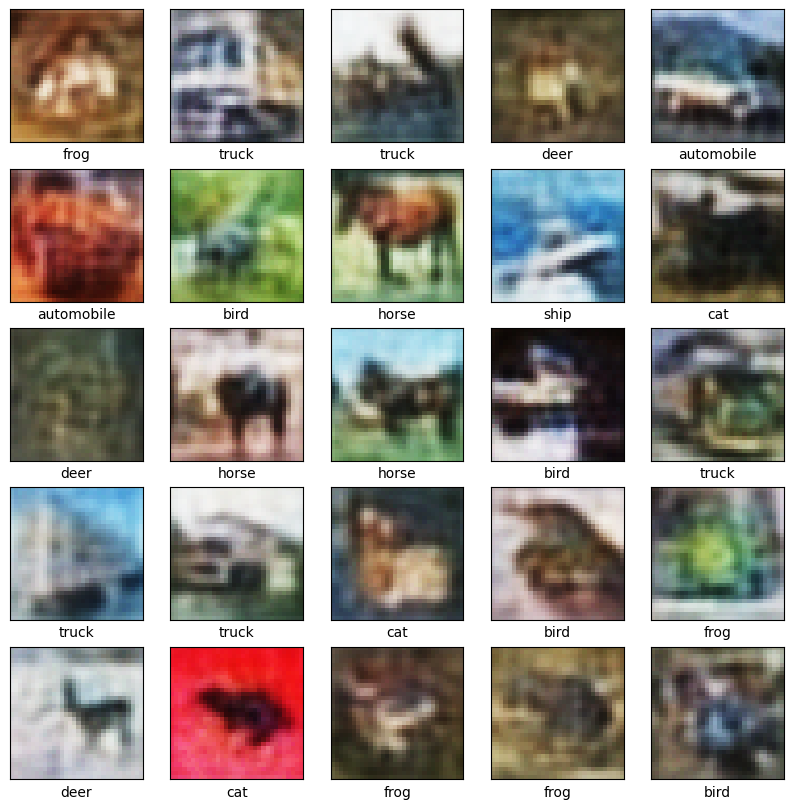

In [43]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

denoised_X_FGSM_train = FGSM_denoising_autoencoder.predict(X_FGSM_train)
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(denoised_X_FGSM_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [44]:
# Run model on PGD and clean data
PGD_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_PGD_train], axis=0), np.concatenate([X_test, X_PGD_test], axis=0), file_name=(file_path + '/models/PGD_denoising_autoencoder2.keras'))

Epoch 1/25
391/391 [==============================] - 59s 149ms/step - loss: 0.0278 - accuracy: 0.5717 - val_loss: 0.0167 - val_accuracy: 0.6659
Epoch 2/25
391/391 [==============================] - 58s 149ms/step - loss: 0.0147 - accuracy: 0.6648 - val_loss: 0.0131 - val_accuracy: 0.6813
Epoch 3/25
391/391 [==============================] - 58s 148ms/step - loss: 0.0120 - accuracy: 0.6755 - val_loss: 0.0102 - val_accuracy: 0.6892
Epoch 4/25
391/391 [==============================] - 58s 148ms/step - loss: 0.0105 - accuracy: 0.6861 - val_loss: 0.0100 - val_accuracy: 0.7006
Epoch 5/25
391/391 [==============================] - 58s 147ms/step - loss: 0.0094 - accuracy: 0.6956 - val_loss: 0.0092 - val_accuracy: 0.7138
Epoch 6/25
391/391 [==============================] - 57s 146ms/step - loss: 0.0088 - accuracy: 0.7030 - val_loss: 0.0075 - val_accuracy: 0.7284
Epoch 7/25
391/391 [==============================] - 57s 147ms/step - loss: 0.0082 - accuracy: 0.7078 - val_loss: 0.0073 - val_ac

In [45]:
# Evaluate original model on denoised clean
model.evaluate(X_PGD_test, y_test)

# Evaluate it on a set the model has never seen
model.evaluate(PGD_denoising_autoencoder.predict(X_PGD_test), y_test)

# Evaluate original model on denoised clean
model.evaluate(PGD_denoising_autoencoder.predict(X_test), y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.5496 - accuracy: 0.5892


[1.5495591163635254, 0.5892000198364258]

1563/1563 [==============================] - 16s 10ms/step


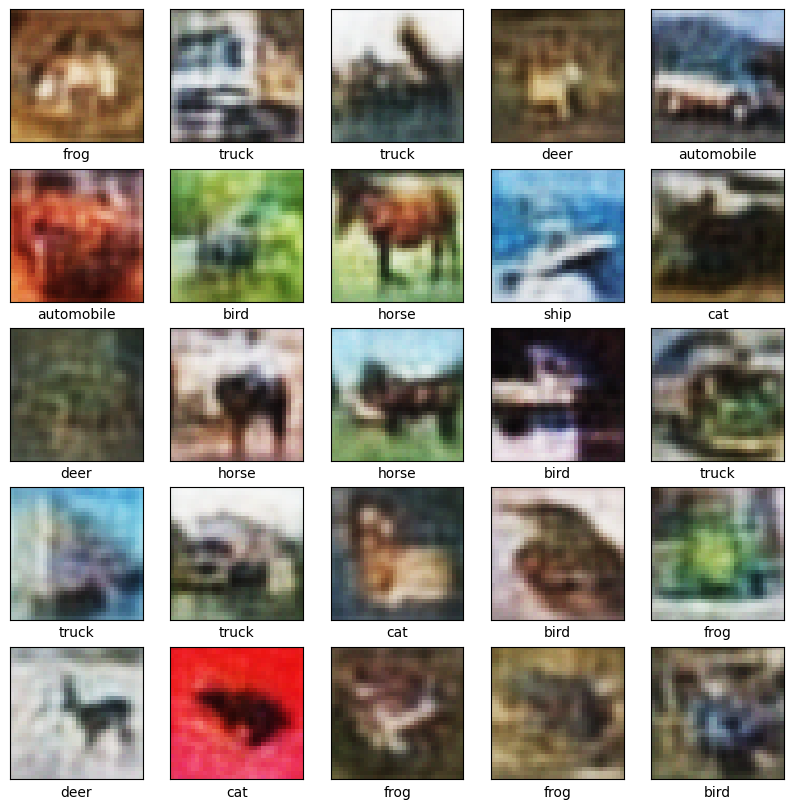

In [46]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

denoised_X_PGD_train = PGD_denoising_autoencoder.predict(X_PGD_train)
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(denoised_X_PGD_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()